In [1]:
import os
import numpy as np 

from plot_params import * 
from math import sqrt
from tqdm import tqdm
from time import time
from joblib import Parallel, delayed
from scipy.stats import qmc, normaltest, norm

In [2]:
# define global constants
real_min = -2
real_max = 0.46
imag_min = -1.12
imag_max = 1.12
area_box = (real_max - real_min) * (imag_max - imag_min)

n_cores = os.cpu_count()
n_samples = 1000

In [3]:
# define global functions

def check_inside_mandlebrot(i, c):
    z = 0 + 0j
    for i in range(i):
        z = z ** 2 + c
        if abs(z) > 2:
            return False
    return True

def mandlebrot_area(i, s, sampling_function):
    random_complex_numbers = sampling_function(s)
    in_mandlebrot = 0
    for z in random_complex_numbers:
        if check_inside_mandlebrot(i, z):
            in_mandlebrot += 1
    area = in_mandlebrot / s * area_box
    return area

def uniform_samples(n):
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = np.random.uniform(imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers


In [4]:
class DetermineNumberRuns():
    def __init__(self, n_samples, default_i, interval_length, z_value, rand_num_generator):
        self.n_samples = n_samples
        self.default_i = default_i
        self.interval_length = interval_length
        self.z_value = z_value
        self.rand_num_generator = rand_num_generator

        self.all_areas = []
        self.all_stop_checks = []

        self.k = 1
        self.sample_mean = 0
        self.sample_var = 0
        self.sample_std = 0
    
    def generate_new_values(self, n_values):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(self.default_i, self.n_samples, self.rand_num_generator) for _ in range(n_values))
        self.all_areas = self.all_areas + areas

        for area in areas:
            new_sample_mean = self.sample_mean + (area - self.sample_mean) / (self.k + 1)
            self.sample_var = (1 - 1 / self.k) * self.sample_var + (self.k + 1) * (new_sample_mean - self.sample_mean) ** 2
            self.sample_mean = new_sample_mean
            self.sample_std = sqrt(self.sample_var)
            self.k += 1

    def keep_going(self):
        check = 2 * self.z_value * self.sample_std / sqrt(self.k)
        self.all_stop_checks.append([self.k, check])
        return check > self.interval_length
    

In [5]:
# determine how many runs we need in order to achieve satiffactory accuracy

dnr = DetermineNumberRuns(
    n_samples=n_samples,
    default_i=50,
    interval_length=0.02,
    z_value=1.96,
    rand_num_generator=uniform_samples
)
dnr.generate_new_values(100)
while dnr.keep_going():
    dnr.generate_new_values(n_cores)

n_runs = dnr.k
print(f'We needed {n_runs} runs to be 95% confident that the area lies within ±{round(dnr.interval_length / 2, 3)} of {round(dnr.sample_mean, 3)}')

We needed 461 runs to be 95% confident that the area lies within ±0.01 of 1.591


In [9]:
# see how fast the area converges based on the number of iterations

class IterationConvergence():
    def __init__(self, max_i, n_samples, n_runs, rand_num_generator):
        self.max_i = max_i
        self.n_samples = n_samples
        self.n_runs = n_runs
        self.rand_num_generator = rand_num_generator
        self.max_mean, self.max_std = self.determine_area(max_i)

    def determine_area(self, i):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(i, self.n_samples, self.rand_num_generator) for _ in range(self.n_runs))
        areas = np.array(areas)
        mean = areas.mean()
        std = areas.std() / sqrt(n_runs)
        return mean, std
    
    def dist_from_max(self, i):
        mean, std = self.determine_area(i)
        mean_diff = mean - self.max_mean
        std_diff = std + self.max_std
        return mean_diff, std_diff


In [10]:
n_different_i = 10
i_values = np.linspace(1000, 100, n_different_i, dtype=int)
means = np.zeros(n_different_i)
stds = np.zeros(n_different_i)

ic = IterationConvergence(
    max_i=1000,
    n_samples=n_samples,
    n_runs=n_runs,
    rand_num_generator=uniform_samples
)

for i in tqdm(range(n_different_i)):
    means[i], stds[i] = ic.dist_from_max(i_values[i])



100%|██████████| 10/10 [01:37<00:00,  9.78s/it]


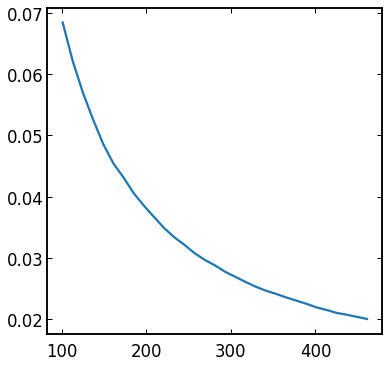

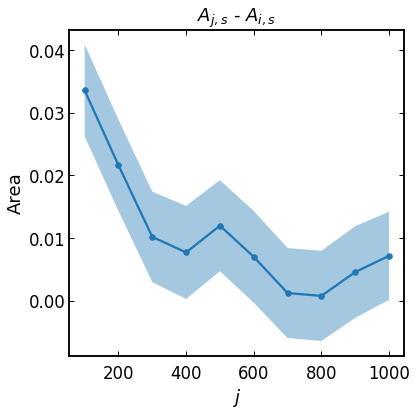

In [11]:
stop_array = np.array(dnr.all_stop_checks)
plt.plot(stop_array[:, 0], stop_array[:, 1])
plt.show()

plt.plot(i_values, means, '-o', markersize=5.5)
plt.fill_between(i_values, means - stds, means + stds, alpha=0.4)
plt.title('$A_{j, s}$ - $A_{i, s}$')
plt.xlabel('$j$')
plt.ylabel('Area')
plt.show()